# Overview
The kernel here is to show how to build and train a model on the MURA dataset focusing specifically on the problem of classifying finger images. We use Keras to build a basic MobileNet model and then use the ImageDataGenerator to handle augmenting the datasets to create enough diversity to get interesting results. The ```image_cat``` is currently set to _XR_FINGER_ but can be easily tweaked to another category like _XR_SHOULDER_

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
#%%
import matplotlib.pyplot as plt # showing and rendering figures
# io related
from skimage.io import imread
import os
import shutil
import pathlib
from glob import glob
import re
# not needed in Kaggle, but required in Jupyter
import tensorflow.compat.v1 as tf
device = tf.config.list_physical_devices('GPU')[0]
print(device)

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


# Prepare distinct directories of images
Since Keras expects the images to be subfolders of a main directory, so we use sym-links to fake this

In [3]:
def make_vdirs_for_keras(dir_list, catdir_name, classes, *args):
    os.makedirs(catdir_name, exist_ok=True)
    for cl in classes:
        os.makedirs(os.path.join(catdir_name, cl), exist_ok=True)
    
    for i, item in enumerate(dir_list):
        item = str(item)
        print(type(item))
        if args[0].search(item) is not None:
            if args[1].search(item) is not None:
                shutil.copyfile(os.path.abspath(item), os.path.abspath(os.path.join(catdir_name, classes[0], f"img{i}.png")))
            else:
                shutil.copyfile(os.path.abspath(item), os.path.abspath(os.path.join(catdir_name, classes[1], f"img{i}.png")))
    
    return catdir_name


def read_csv(path):
    if not os.path.exists(path):
        raise(FileNotFoundError) 
    with open(path, "r") as train:
        train_path = train.readlines()
    train.close()
    return train_path

In [41]:
# image_cat = 'XR_FINGER'
image_cat = 'XR_SHOULDER'
# image_cat = 'XR_FOREARM'
CLASSES = ["positive", "negative"]

train_paths = list(pathlib.Path("data/MURA-v1.1/train/").rglob("*.png"))
valid_paths = list(pathlib.Path("data/MURA-v1.1/valid/").rglob("*.png"))

# reg = re.compile("/^(?=.*\bXR_FINGER\b)(?=.*\bpositive\b).*$/m")
reg1 = re.compile(image_cat)
reg2 = re.compile("positive")

keras_train_dirs = make_vdirs_for_keras(train_paths, 'v_train',CLASSES, reg1, reg2)
keras_valid_dirs = make_vdirs_for_keras(valid_paths, 'v_valid',CLASSES, reg1, reg2)

<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class

# Build the data generator

In [42]:
from keras.preprocessing.image import ImageDataGenerator


idg_train_settings = dict(
    samplewise_center = True,
    samplewise_std_normalization = True,
    rotation_range = 10, 
    width_shift_range = 0.1, 
    height_shift_range = 0.1,
    zoom_range = 0.1, 
    horizontal_flip = True,
    vertical_flip = True)

idg_train = ImageDataGenerator(**idg_train_settings)

idg_valid_settings = dict(
    samplewise_center = True,
    samplewise_std_normalization = True,
    rotation_range = 0, 
    width_shift_range = 0., 
    height_shift_range = 0.,
    zoom_range = 0.0, 
    horizontal_flip = False,
    vertical_flip = False)

idg_valid = ImageDataGenerator(**idg_valid_settings)

In [43]:
BATCH_SIZE = 32
TARGET_SIZE = (128, 128)
train_gen = idg_train.flow_from_directory('v_train', 
    # class_mode='binary',
    follow_links = True, 
    target_size=TARGET_SIZE, 
    color_mode = 'grayscale',
    batch_size=BATCH_SIZE
)

valid_gen = idg_valid.flow_from_directory('v_valid', 
    # class_mode='binary',
    follow_links = True, 
    target_size=TARGET_SIZE, 
    color_mode = 'grayscale',
    batch_size=BATCH_SIZE
)

valid_flow = idg_valid.flow_from_directory('v_valid', 
    # class_mode='binary',
    follow_links = True, 
    target_size=TARGET_SIZE, 
    color_mode = 'grayscale',
    shuffle = False)
a, b = next(train_gen)
print(a.shape, a.mean(), a.min(), a.max())
print(b.shape)
print(train_gen.class_indices)
print(valid_gen.class_indices)

Found 8379 images belonging to 2 classes.
Found 563 images belonging to 2 classes.
Found 563 images belonging to 2 classes.
(32, 128, 128, 1) 1.8626451e-09 -4.373602 12.69467
(32, 2)
{'negative': 0, 'positive': 1}
{'negative': 0, 'positive': 1}


# Verify Images
Here we verify the images are loading correctly, are readable and deliver reasonably understandable results

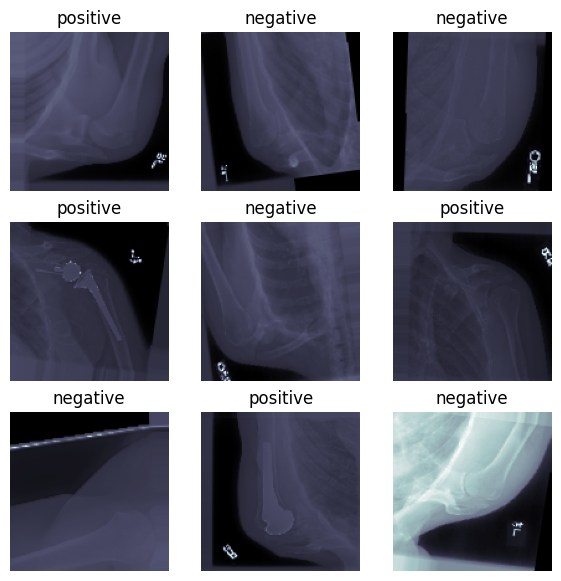

In [44]:
tg_class = {v:k for k,v in train_gen.class_indices.items()}
fig, m_axs = plt.subplots(3, 3, figsize = (7, 7))
for c_ax, c_img, c_lab in zip(m_axs.flatten(), a, b):
    c_ax.imshow(c_img[:,:,0], cmap = 'bone')
    c_ax.axis('off')
    c_ax.set_title(tg_class[np.argmax(c_lab)])

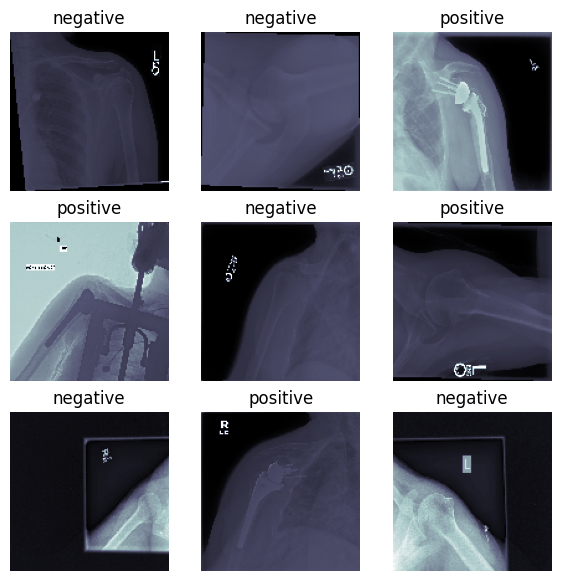

In [45]:
a, b = next(valid_gen)
vg_class = {v:k for k,v in valid_gen.class_indices.items()}
fig, m_axs = plt.subplots(3, 3, figsize = (7, 7))
for c_ax, c_img, c_lab in zip(m_axs.flatten(), a, b):
    c_ax.imshow(c_img[:,:,0], cmap = 'bone')
    c_ax.axis('off')
    c_ax.set_title(tg_class[np.argmax(c_lab)])

# Build a Model
We use an untrained MobileNet to process the images

In [46]:
a.shape

(32, 128, 128, 1)

In [47]:
tr_a, tr_b = next(train_gen)
print(a.shape, b.shape)
print(tr_a.shape, tr_b.shape)

(32, 128, 128, 1) (32, 2)
(32, 128, 128, 1) (32, 2)


# Finetune

In [48]:
from keras.layers import Flatten,Dense,Dropout,BatchNormalization, GlobalAveragePooling2D, GlobalAveragePooling3D
from keras.regularizers import l2
from keras import Sequential
from keras.models import Model

from classification_models.tfkeras import Classifiers
import keras
from keras import layers
# from keras.applications.densenet import DenseNet169, DenseNet201
# from keras.applications.inception_v3 import InceptionV3
ResNeXt50, preprocess_input1 = Classifiers.get('resnext50')
DenseNet169, preprocess_input2 = Classifiers.get('densenet169')
DenseNet201, preprocess_input3 = Classifiers.get('densenet201')
InceptionV3, preprocess_input4 = Classifiers.get('inceptionv3')
MobileNetV2, preprocess_input5 = Classifiers.get('mobilenetv2')
shape = tr_a.shape[1:]
input_shape = layers.Input(shape=shape)
# in1 = preprocess_input1(input_shape)
# in2 = preprocess_input2(input_shape)
# in3 = preprocess_input3(input_shape)
# in4 = preprocess_input4(input_shape)
in1 = in2 = in3 = in4 = in5 = input_shape
# resnext50 =   ResNeXt50(include_top=False, input_shape=shape, weights=None)(in1)
dense169  = DenseNet169(input_shape=shape, include_top=False, weights=None)(in2)
dense201  = DenseNet201(input_shape=shape, include_top=False, weights=None)(in3)
inception = InceptionV3(input_shape=shape, include_top=False, weights=None)(in4)
mobilenetv2 = MobileNetV2(input_shape=shape, include_top=False, weights=None)(in5)
f1 = GlobalAveragePooling2D()(BatchNormalization()(dense169))
# f2 = GlobalAveragePooling2D()(resnext50)
f3 = GlobalAveragePooling2D()(BatchNormalization()(dense201))
f4 = GlobalAveragePooling2D()(inception)
f5 = GlobalAveragePooling2D()(mobilenetv2)
# f1 = Flatten()(dense169)
# f2 = Flatten()(resnext50)
# f3 = Flatten()(inception)

merged = keras.layers.concatenate([f1, f3, f4])#, f2, f3])

l1 = Dense(merged.shape[-1], activation='softmax')(merged)
l2 = Dense(2, activation='sigmoid')(l1)

model = Model(inputs=input_shape, outputs=l2)
# model.summary()
keras.utils.plot_model(model, "arch.png", show_shapes=True)

In [88]:
from classification_models.tfkeras import Classifiers
import keras
from keras import layers
from keras.applications.densenet import DenseNet169, DenseNet201
from keras.applications.inception_v3 import InceptionV3
from keras.applications.xception import Xception
shape = tr_a.shape[1:]
input_shape = layers.Input(shape=shape)
dense169  = DenseNet169(input_shape=shape, classes=2, weights=None)
dense201  = DenseNet201(input_shape=shape, classes=2, weights=None)
inception = InceptionV3(input_shape=shape, classes=2, weights=None)
xception = Xception(input_shape=shape, classes=2, weights=None)


In [89]:
s_net = xception
# keras.utils.plot_model(s_net, "arch.png", show_shapes=True)

In [90]:

s_net.compile(optimizer='adam', loss='categorical_crossentropy', metrics = ['acc'])

In [91]:
# from keras.applications.densenet import DenseNet169
# s_net = DenseNet169(classes=tr_b.shape[1], weights = None, input_shape=tr_a.shape[1:])
# s_net.compile(optimizer='adam', loss='categorical_crossentropy', metrics = ['acc'])

In [92]:
print('Layers: {}, parameters: {}'.format(len(s_net.layers), s_net.count_params()))

Layers: 134, parameters: 20865002


In [93]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
file_path="weights.best.hdf5"
checkpoint = ModelCheckpoint(file_path, monitor='val_loss', 
                             verbose=1, save_best_only=True, mode='min')
# save_dir = os.path.join(os.getcwd(), "save_models")
# # save_dir = os.path.abspath('./weights/')
# filepath = "weights.rf"
# # filepath = "cnn_cnn_weights.{epoch:02d}-{val_loss:.4f}--0fold.tf"
# checkpoint = ModelCheckpoint(os.path.join(save_dir, filepath),
#                              monitor="val_loss", verbose=1, save_best_only=True, mode='min')
early = EarlyStopping(monitor="val_acc", mode="max", patience=3)
callbacks_list = [checkpoint, early] #early

In [95]:
history = s_net.fit(train_gen,
    steps_per_epoch = 120, 
    validation_data = valid_gen,
    validation_steps = 10,
    epochs=120
    # callbacks = callbacks_list
)

Epoch 1/120
120/120 [==============================] - 13s 112ms/step - loss: 0.6581 - acc: 0.6039 - val_loss: 0.6620 - val_acc: 0.5688
Epoch 2/120
120/120 [==============================] - 13s 112ms/step - loss: 0.6525 - acc: 0.6195 - val_loss: 0.8386 - val_acc: 0.5938
Epoch 3/120
120/120 [==============================] - 14s 112ms/step - loss: 0.6423 - acc: 0.6336 - val_loss: 0.6804 - val_acc: 0.6031
Epoch 4/120
120/120 [==============================] - 14s 112ms/step - loss: 0.6441 - acc: 0.6320 - val_loss: 0.5893 - val_acc: 0.6938
Epoch 5/120
120/120 [==============================] - 14s 113ms/step - loss: 0.6325 - acc: 0.6411 - val_loss: 0.6465 - val_acc: 0.6719
Epoch 6/120
120/120 [==============================] - 14s 112ms/step - loss: 0.6308 - acc: 0.6422 - val_loss: 0.6433 - val_acc: 0.6094
Epoch 7/120
120/120 [==============================] - 14s 113ms/step - loss: 0.6303 - acc: 0.6510 - val_loss: 0.6163 - val_acc: 0.6313
Epoch 8/120
120/120 [===========================

In [96]:
def plot_lr_curve(history):
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('acc')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.ylim([0, 1.25])
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

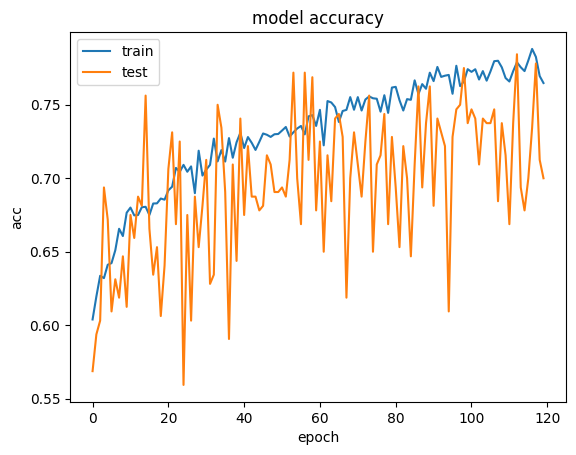

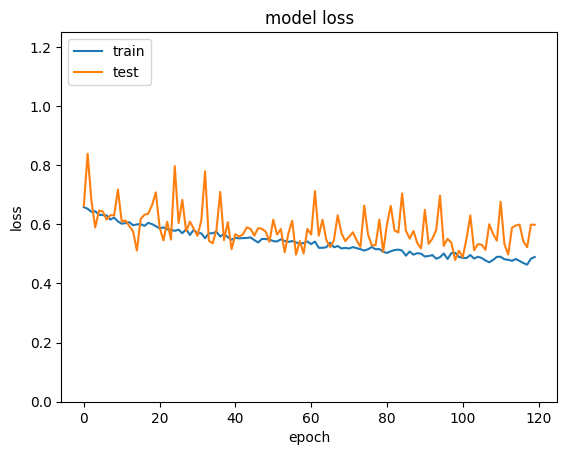

In [97]:
plot_lr_curve(history)

# Run the validation data
Here we run the validation data with minimal augmentation to see how well it performs and calculate a few stats

In [72]:
# s_net.load_weights(file_path) # load the best model

In [98]:
from tqdm import tqdm

out_x, out_y, pred_y = [], [], []
for _, (tX, tY) in zip(tqdm(range(len(valid_flow.filenames)//32)), valid_flow):
    out_x += [tX]
    out_y += [tY]
    pred_y += [s_net.predict(tX)]

  0%|          | 0/17 [00:00<?, ?it/s]

1/1 [==============================] - 0s 316ms/step


  6%|▌         | 1/17 [00:00<00:06,  2.53it/s]

1/1 [==============================] - 1s 636ms/step


 12%|█▏        | 2/17 [00:01<00:08,  1.77it/s]

1/1 [==============================] - 0s 12ms/step


 24%|██▎       | 4/17 [00:01<00:03,  3.77it/s]

1/1 [==============================] - 0s 13ms/step


 35%|███▌      | 6/17 [00:01<00:01,  5.53it/s]

1/1 [==============================] - 0s 12ms/step


 47%|████▋     | 8/17 [00:01<00:01,  7.00it/s]

1/1 [==============================] - 0s 12ms/step


 59%|█████▉    | 10/17 [00:01<00:00,  8.27it/s]

1/1 [==============================] - 0s 12ms/step


 71%|███████   | 12/17 [00:01<00:00,  9.22it/s]

1/1 [==============================] - 0s 12ms/step


 82%|████████▏ | 14/17 [00:02<00:00,  9.83it/s]

1/1 [==============================] - 0s 12ms/step


 94%|█████████▍| 16/17 [00:02<00:00, 10.36it/s]

1/1 [==============================] - 0s 13ms/step


100%|██████████| 17/17 [00:02<00:00,  7.17it/s]


In [99]:
# concatenate to single array
out_cat_y = np.argmax(np.concatenate(out_y, 0), -1)
pred_cat_y = np.argmax(np.concatenate(pred_y, 0), -1)
pred_conf_y = np.concatenate(pred_y, 0)[:,1]

              precision    recall  f1-score   support

           0       0.78      0.58      0.66       285
           1       0.62      0.81      0.70       246

    accuracy                           0.68       531
   macro avg       0.70      0.69      0.68       531
weighted avg       0.71      0.68      0.68       531



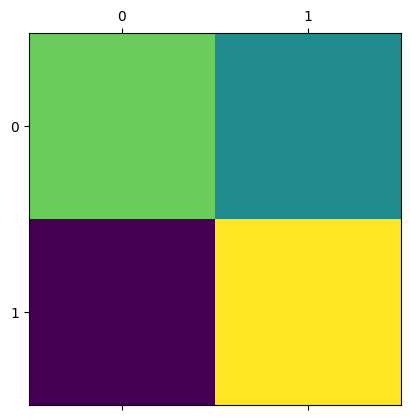

In [100]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(out_cat_y, pred_cat_y))
plt.matshow(confusion_matrix(out_cat_y, pred_cat_y))

# Make an ROC
Here we create a simple ROC curve to evaluate the model

Text(0, 0.5, 'True Positive Rate')

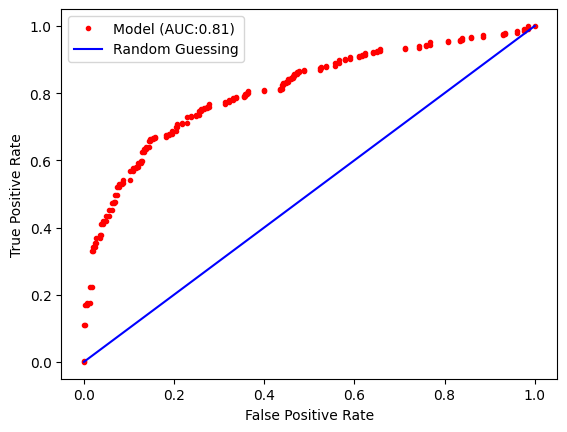

In [101]:
from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, thresholds = roc_curve(out_cat_y, pred_conf_y)
fig, ax1 = plt.subplots(1,1)
ax1.plot(fpr, tpr, 'r.', label = 'Model (AUC:%2.2f)' % roc_auc_score(out_cat_y, pred_conf_y))
ax1.plot(fpr, fpr, 'b-', label = 'Random Guessing')
ax1.legend()
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')

In [25]:
# clean up the virtual directories
import shutil
for c_dir in glob('v_*'):
    shutil.rmtree(c_dir)